새로 알게 된 테크닉
1. padding
2. subclass api를 통한 modeling 에서 get_summary 설정

In [1]:
_pad = tf.constant([
    [30,30], # height 상,하
    [30,30], # width 좌,우
    [0,0] # channel
])

padded1 = tf.pad(colored, _pad, "REFLECT") # 반사 패딩
padded2 = tf.pad(colored, _pad, "CONSTANT") # 상수 값 패딩 default=0
padded3 = tf.pad(colored, _pad, "CONSTANT", constant_values=1.)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(padded1)
plt.subplot(1,3,2); plt.imshow(padded2)
plt.subplot(1,3,3); plt.imshow(padded3)

NameError: name 'tf' is not defined

In [ ]:
def get_summary(self, input_shape=(1,1,512)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

# Pix2Pix

In [6]:
a=1
b=2
c=3

In [1]:
import os
import sys
import logging

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 데이터

In [2]:
data_path = '../data/ex16/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))
print(os.listdir(data_path)[:10])

number of train examples : 830
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg']


### Sample

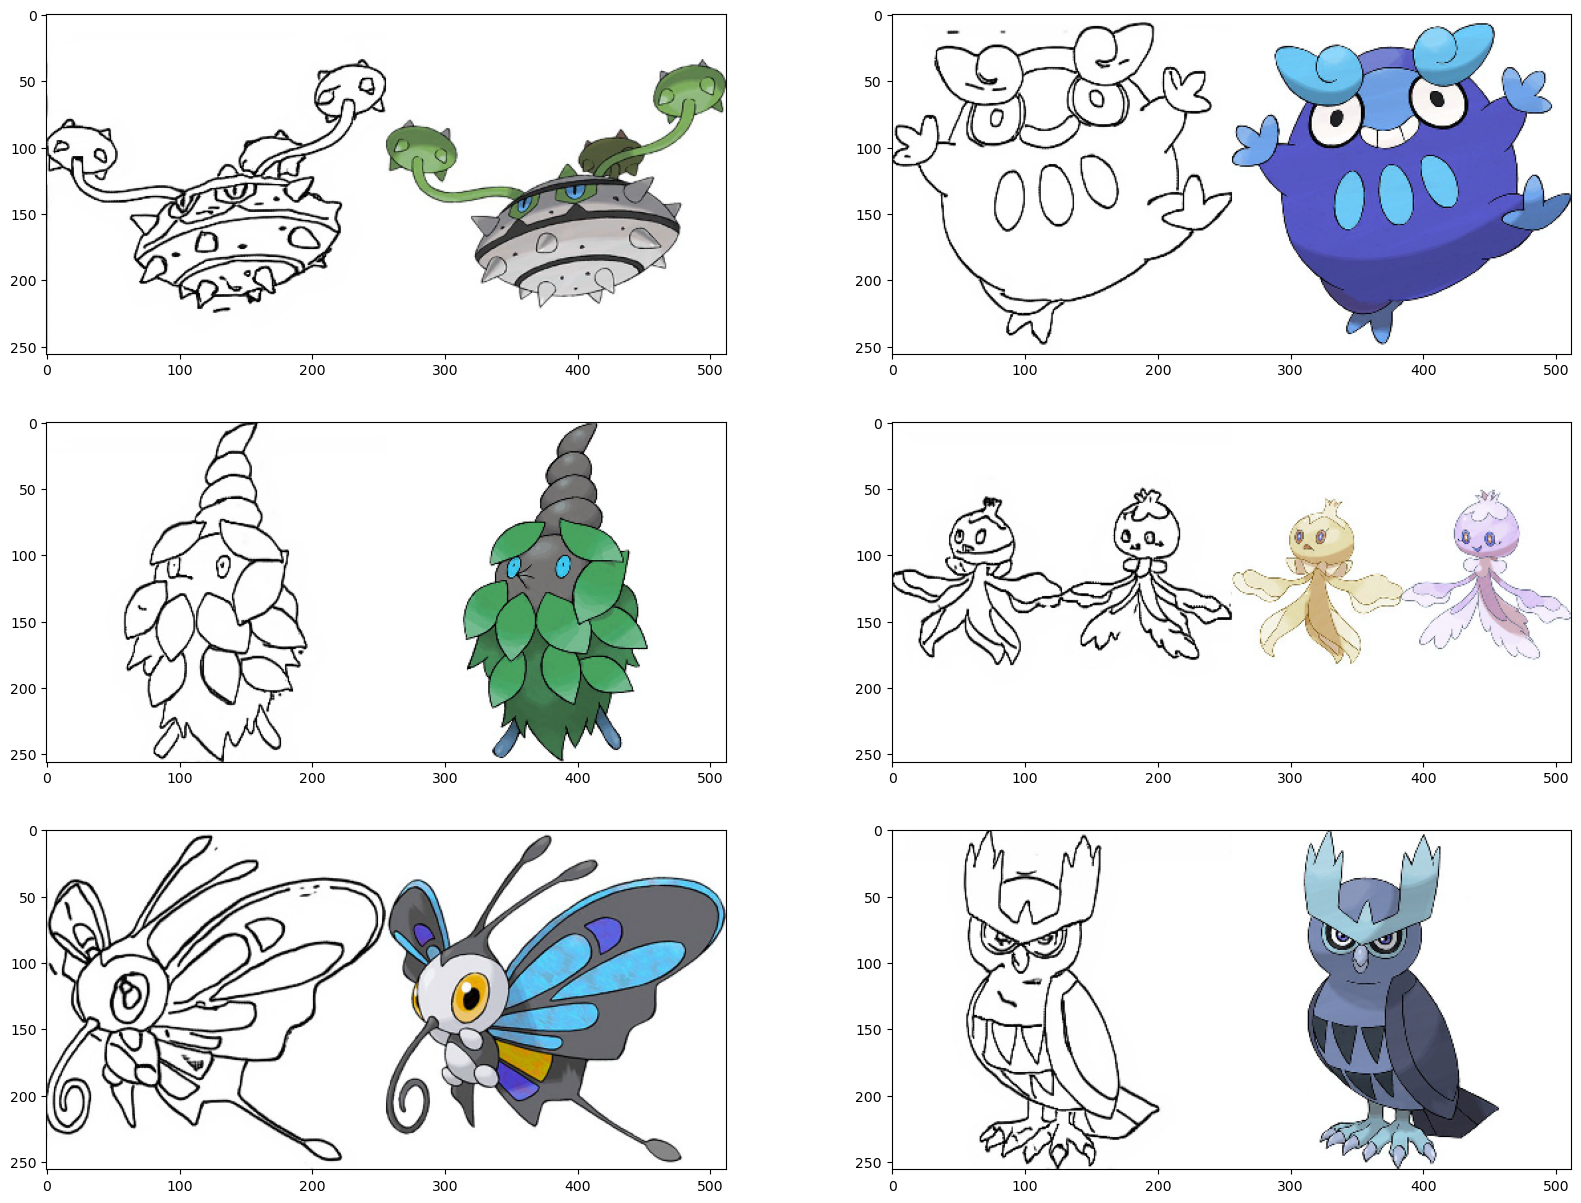

In [5]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [6]:
# 이미지 하나의 크기
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


### 전처리

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


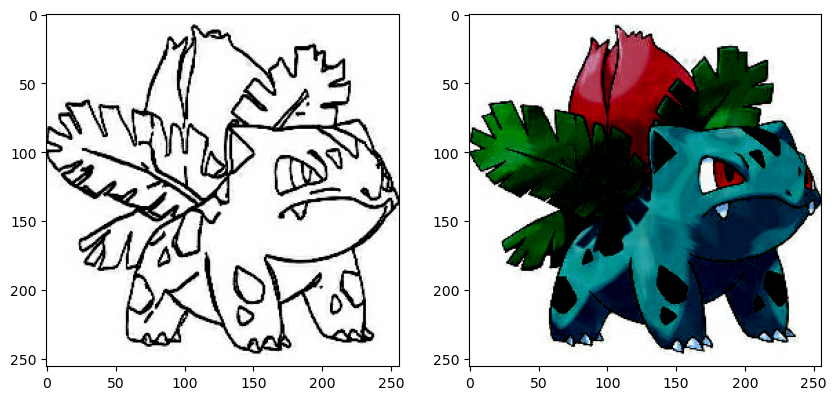

In [30]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]

sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(sketch)
plt.subplot(1,2,2); plt.imshow(colored)

### 증강

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


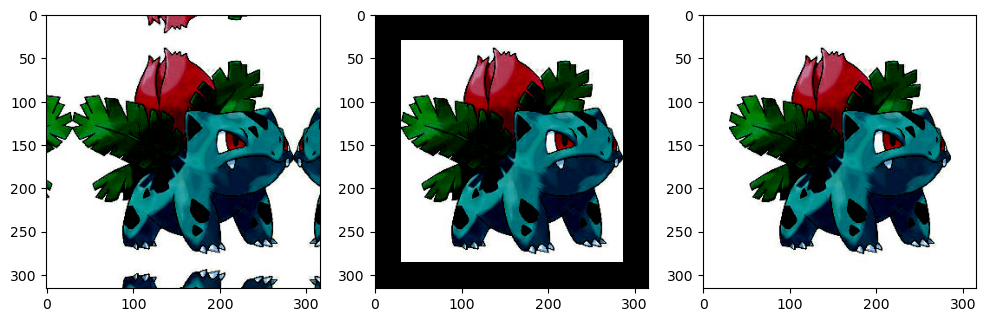

In [31]:
_pad = tf.constant([
    [30,30], # height 상,하
    [30,30], # width 좌,우
    [0,0] # channel
])

padded1 = tf.pad(colored, _pad, "REFLECT") # 반사 패딩
padded2 = tf.pad(colored, _pad, "CONSTANT") # 상수 값 패딩 default=0
padded3 = tf.pad(colored, _pad, "CONSTANT", constant_values=1.)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(padded1)
plt.subplot(1,3,2); plt.imshow(padded2)
plt.subplot(1,3,3); plt.imshow(padded3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


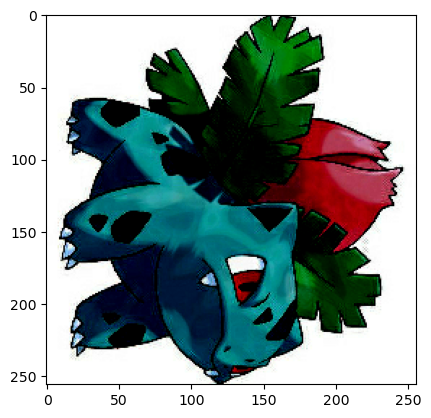

In [32]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32) #1~4 random
img = image.rot90(colored, k=3) # 0,4:원본, 1:반시계90,2:180도,3:시계90
plt.imshow(img)

In [33]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

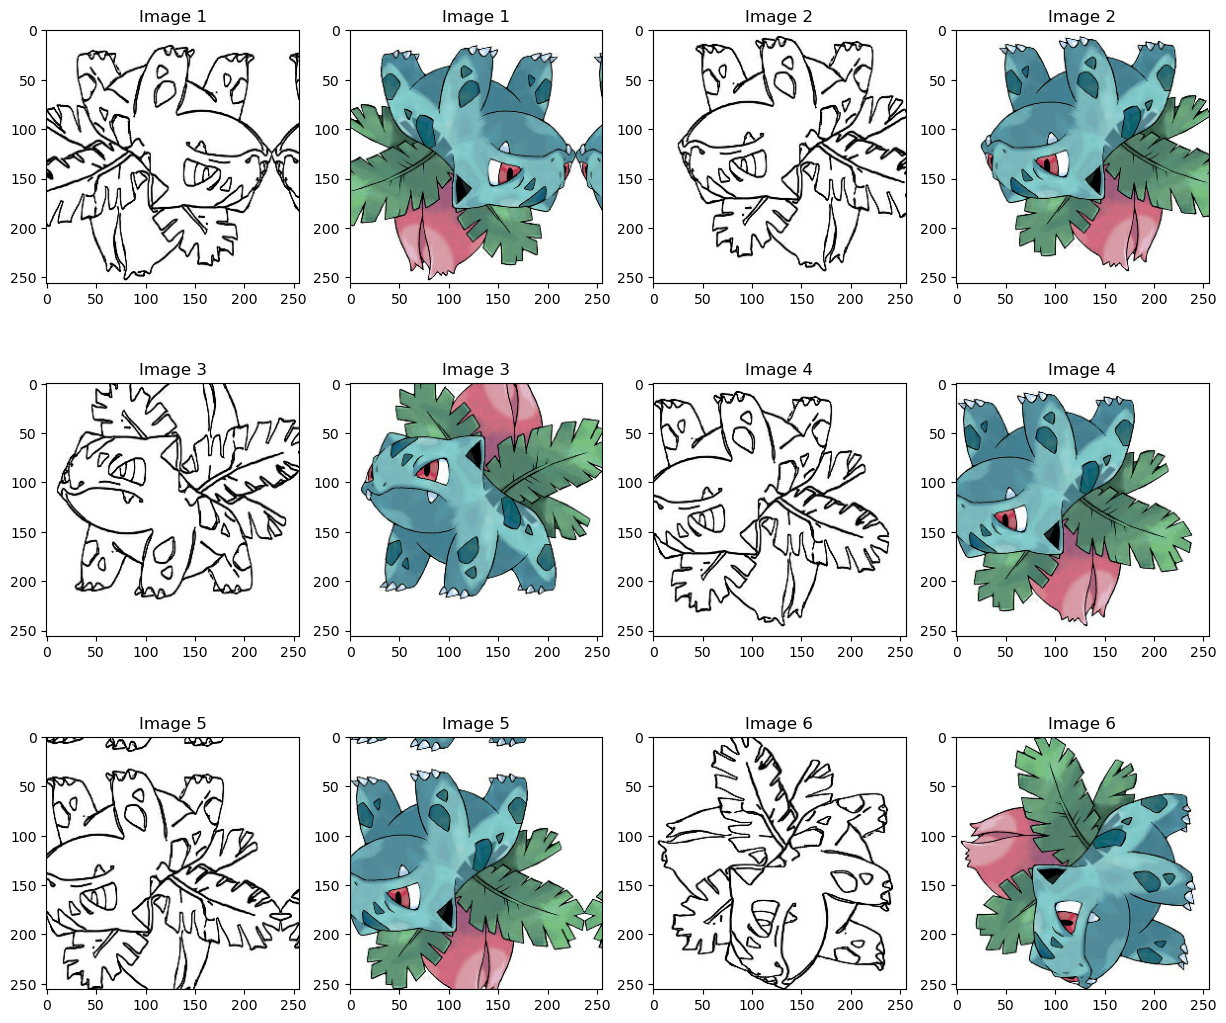

In [34]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

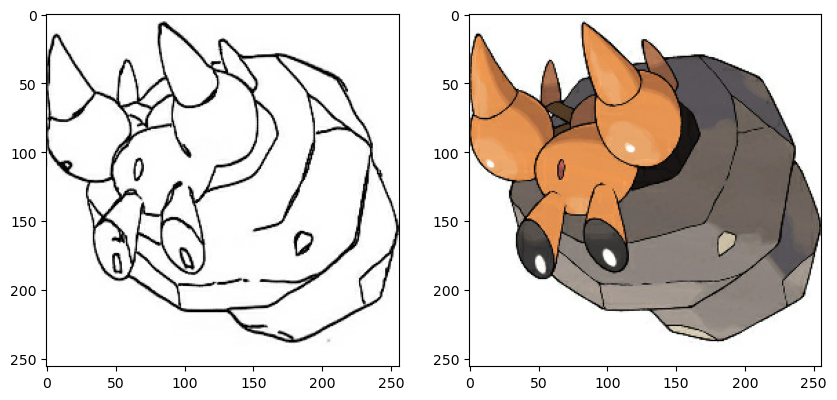

In [55]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(2)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 모델

### Gene

### Encode 블록

In [56]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


### Encoder

In [57]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [58]:
Encoder().get_summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_56 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_57 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_58 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_59 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                       

### Decode 블록

In [59]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### Decoder

In [60]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [61]:
Decoder().get_summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 1, 512)]       0         
                                                                 
 decode_block_49 (DecodeBloc  (None, 2, 2, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_50 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_51 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_52 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                       

### Encoder-Decoder Gene

In [62]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encoder_5 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_5 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________



### Unet Generator

In [63]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # unet에는 encoder의 feature들을 받아둔다
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # 가장 마지막 feature는 제외
        features = features[:-1]
        
        # encoder의 feature를 뒤집어서 decoder에 연결
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [64]:
UNetGenerator().get_summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_72 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 encode_block_73 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_72[0][0]']        
                                                                                           

### Disc

Pix2Pix가 70X70 크기의 PatchGAN을 사용하기 때문에 30X30의 output을 위해 맞춤형 padding을 사용합니다

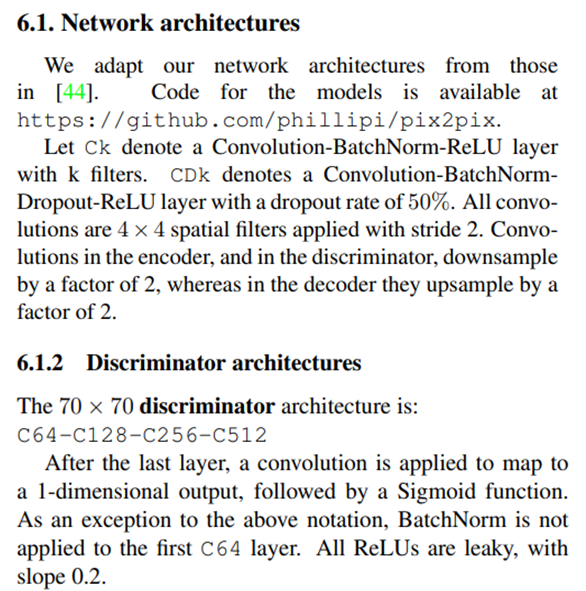
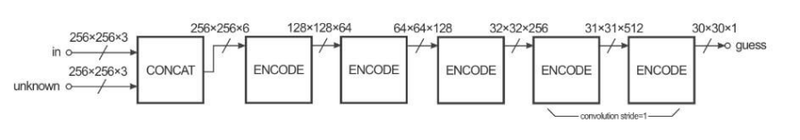
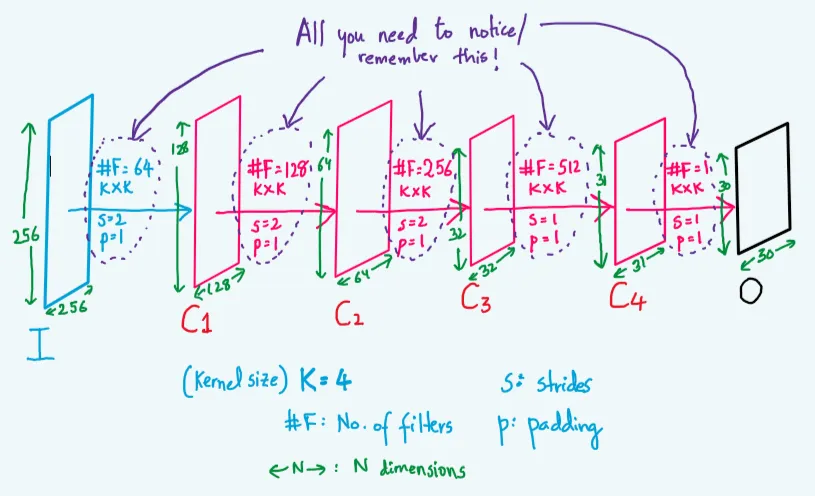

### DiscBlock

In [65]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        
        self.custom_pad = custom_pad # 32,31,30 을 맞추기 위해
        self.use_bn = use_bn # 첫 레이어에는 적용 x
        self.act = act # leaky_relu + 마지막은 sigmoid
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32)의 data를 통과하면

* 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)
* Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64) → `(n-k+2p)/s + 1 | (130-6+4)/1 + 1`

* BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
* LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

In [66]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_12 (ZeroPadd  (None, 130, 130, 32)     0         
 ing2D)                                                          
                                                                 
 conv2d_107 (Conv2D)         (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_167 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_102 (LeakyReLU)  (None, 127, 127, 64)     0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainabl

### Discriminator

In [67]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [68]:
Discriminator().get_summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_21 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_33 (Concatenate)   (None, 256, 256, 6)  0           ['input_20[0][0]',               
                                                                  'input_21[0][0]']        

In [69]:
# sample
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
disc_out.shape

TensorShape([1, 30, 30, 1])

## 학습

In [70]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False) # sigmoid를 사용했기 때문에
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    # fake_disc : Disc(fake_image) → gene_loss
    # fake_output : MAE(fake_output, real_output) → L1 Loss
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    # real_image disc
    # fake_image disc
    # sum
    return 0.5*bce(tf.zeros_like(fake_disc), fake_disc) + 0.5*bce(tf.ones_like(real_disc), real_disc)

In [71]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [72]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True) # fake_colored = fake_image
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [73]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(EPOCHS):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
    #반복마다 손실을 출력합니다.
    print(f"EPOCH[{epoch}] \t| Generator_loss:{g_loss.numpy():.6f}\t|L1_loss:{l1_loss.numpy():.6f}\t|Discriminator_loss:{d_loss.numpy():.6f}")

EPOCH[0] 	| Generator_loss:2.230099	|L1_loss:0.304514	|Discriminator_loss:0.080399
EPOCH[1] 	| Generator_loss:2.364386	|L1_loss:0.292707	|Discriminator_loss:0.095588
EPOCH[2] 	| Generator_loss:3.332374	|L1_loss:0.261149	|Discriminator_loss:0.113521
EPOCH[3] 	| Generator_loss:2.982255	|L1_loss:0.306349	|Discriminator_loss:0.084689
EPOCH[4] 	| Generator_loss:1.326452	|L1_loss:0.208015	|Discriminator_loss:0.227843
EPOCH[5] 	| Generator_loss:1.729956	|L1_loss:0.258835	|Discriminator_loss:0.352402
EPOCH[6] 	| Generator_loss:1.919223	|L1_loss:0.230876	|Discriminator_loss:0.096564
EPOCH[7] 	| Generator_loss:4.229733	|L1_loss:0.216224	|Discriminator_loss:0.968017
EPOCH[8] 	| Generator_loss:1.943373	|L1_loss:0.194090	|Discriminator_loss:0.291620
EPOCH[9] 	| Generator_loss:0.611315	|L1_loss:0.257340	|Discriminator_loss:0.743796
EPOCH[10] 	| Generator_loss:2.158582	|L1_loss:0.221481	|Discriminator_loss:0.280042
EPOCH[11] 	| Generator_loss:1.611686	|L1_loss:0.203458	|Discriminator_loss:0.270819
EP

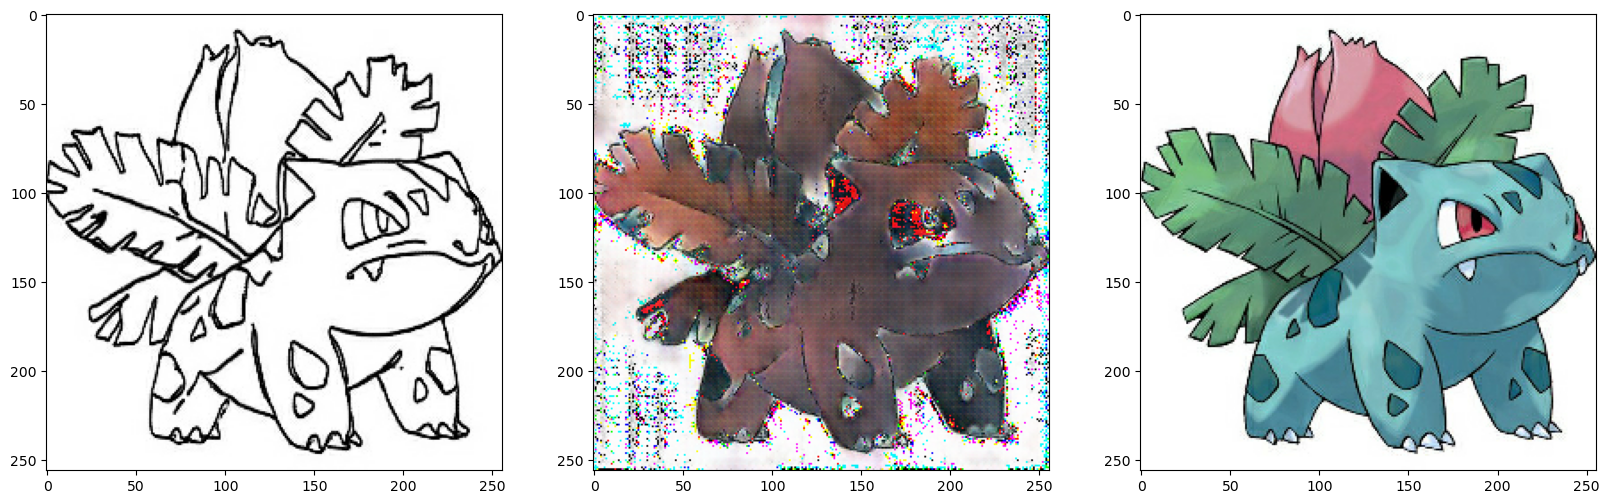

In [74]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))